<a href="https://colab.research.google.com/github/lulmer/heartbeat_classifier/blob/master/heartbeat_model_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projet EDTS | Classification de battements de cœur
---

### Arnaud QUILLENT et Louis ULMER

# Architecture CNN

In [0]:
# Montage du disque Google Drive sur le point /content/drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Chemin d'accès au dataset
path = "drive/My Drive/INSA/ASI 5/EDTS/"

In [0]:
# Imports des utilitaires
import scipy.io.wavfile
import scipy.signal
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import librosa
import librosa.display
from tqdm import tqdm

In [0]:
np.random.seed(3581797089) # Fixation de la seed

In [0]:
files = list(Path(path + "dataset").rglob("Btraining_*/*.wav")) # Liste contenant le chemin d'accès aux fichiers du dataset

In [0]:
# Fonction retournant le label d'un fichier
def labelling(cats, file):
    for i, cat in enumerate(cats):
        if cat in file.parts[6]:
            return i

**Classes :**


* `0` : Normal
* `1` : Murmur
* `2` : Extra-systole



In [0]:
cats = list(reversed(np.unique([file.parts[6] for file in files]))) # Noms des différentes classes

In [0]:
cats_files = [labelling(cats, file) for file in files] # Liste contenant tous les labels des fichiers du dataset

In [0]:
# Séparation en jeux d'apprentissage, validation et test
# Utilisation de stratify = mêmes proportions de classes dans chacun des jeux créés
idx_train, idx_val = train_test_split(range(len(files)), test_size=0.3, stratify=cats_files)
idx_train, idx_test = train_test_split(idx_train, test_size=33, stratify=np.array(cats_files)[idx_train])

In [0]:
# Récupération des chemins vers les fichiers suivant la répartition en jeux d'apprentissage, validation et test
files_train = np.array(files)[idx_train]
files_val = np.array(files)[idx_val]
files_test = np.array(files)[idx_test]

In [0]:
# Récupération des labels des jeux d'apprentissage, validation et test
y_train = np.array(cats_files)[idx_train]
y_val = np.array(cats_files)[idx_val]
y_test = np.array(cats_files)[idx_test]

In [0]:
# Imports des modules de Deep Learning
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Softmax, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, History, EarlyStopping
from sklearn.metrics import classification_report

In [0]:
# Fonction convertissant une liste de fichiers en liste de spectrogrammes de Mel
def to_spect(files):
  x = np.empty((len(files), 128, 98)) # Initialisation de la matrice
  for i, file in enumerate(tqdm(files)): # Pour chaque fichier de la liste (tqdm => affichage d'une barre de progression)
    y, sr = librosa.load(file) # Ouverture du fichier, y = signal, sr = fréquence d'échantillonnage
    # Pour que les spectrogrammes fassent tous la même taille, on fixe la longueur des signaux
    if len(y) > 50000: # Si le signal est plus grand que 50000 valeurs
      y = y[:50000] # On ne prend que les 50000 premières
    elif len(y) < 50000: # Sinon
      n_repet = int(np.ceil(50000/len(y))) # On calcule le nombre de répétitions du signal nécessaires
      y = np.tile(y, n_repet)[:50000] # On répète le signal suivant ce nombre, et on en garde les 50000 premières valeurs
    y = y/np.max(np.abs(y)) # Normalisation par le maximum
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512) # Calcul du spectrogramme de Mel
    # (taille de fenêtre FFT = 2048, temps entre 2 frames = 512)(cf. papiers)
    S_DB = librosa.power_to_db(S, ref=np.max) # Conversion en décibels
    ss = (S_DB - np.mean(S_DB))/np.std(S_DB) # Réduction/centrage
    ss = (ss - np.min(ss))/(np.max(ss)-np.min(ss)) # Normalisation min-max du spectrogramme => valeurs dans [0..1]
    x[i,:,:] = ss # On ajoute le spectrogramme à la matrice
  return x

In [0]:
# Création des matrices d'apprentissage, validation et test
x_train = to_spect(files_train)
x_val = to_spect(files_val)
x_test = to_spect(files_test)

100%|██████████| 33/33 [00:11<00:00,  3.60it/s]


In [0]:
# CNN attendent une entrée de taille (TAILLE_BATCH, HAUTEUR, LARGEUR, CANAUX) => on ajoute une dimension de 1 pour nos canaux
x_train = np.expand_dims(x_train, 3)
x_val = np.expand_dims(x_val, 3)
x_test = np.expand_dims(x_test, 3)

In [0]:
# Modèle de CNN
def CNN():
  cnn = Sequential()
  cnn.add(InputLayer(input_shape=(128, 98, 1))) # Tous les spectrogrammes sont de taille (128, 98)
  cnn.add(Conv2D(32, 3)) # 32 filtres, fenêtre de taille (3,3)
  cnn.add(MaxPool2D(2))
  cnn.add(Conv2D(64, 3)) # 64 filtres
  cnn.add(MaxPool2D(2))
  cnn.add(Conv2D(128, 3)) # 128 filtres
  cnn.add(MaxPool2D(2))
  cnn.add(Conv2D(256, 3)) # 256 filtres
  cnn.add(MaxPool2D(2))
  cnn.add(Flatten()) # Conversion en un long vecteur de taille 256*hauteur*largeur
  cnn.add(Dense(3)) # Full connection vers 3 classes
  cnn.add(Softmax()) # Prédiction de probabilités
  return cnn

In [0]:
# Affichage des couches, tailles et paramètres du modèle
cnn = CNN()
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 96, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 8, 256)        2

In [0]:
# Utilisation de l'optimiseur Adam, car propose un taux d'apprentissage adaptatif
opti = Adam(lr=0.01)

In [0]:
# Compilation du graphe du modèle
# Classification => Crossentropy
# On cherche à maximiser la précision du modèle, en minimisant son entropie croisée
cnn.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer=opti)

In [0]:
# Callbacks Keras
# Sauvegarde les poids du modèle à l'epoch où la précision est maximal
chkpt_acc = ModelCheckpoint(filepath=path+"best_acc.hdf5", monitor="val_acc", save_best_only=True, mode="max", verbose=1)
# Sauvegarde les poids du modèle à l'epoch où l'entropie est minimale
chkpt_loss = ModelCheckpoint(filepath=path+"best_loss.hdf5", monitor="val_loss", save_best_only=True, mode="min", verbose=1)

In [0]:
# Apprentissage
# Hyperparamètres choisis suite à plusieurs essais
history = cnn.fit(x=x_train, y=to_categorical(y_train), epochs=40, batch_size=17, validation_data=(x_val, to_categorical(y_val)), callbacks=[chkpt_acc, chkpt_loss])

Train on 289 samples, validate on 139 samples
Epoch 1/40
238/289 [=======================>......] - ETA: 0s - loss: 83.5484 - acc: 0.4328
Epoch 00001: val_acc improved from -inf to 0.62590, saving model to drive/My Drive/INSA/ASI 5/EDTS/best_acc.hdf5

Epoch 00001: val_loss improved from inf to 8.77649, saving model to drive/My Drive/INSA/ASI 5/EDTS/best_loss.hdf5
289/289 [==============================] - 3s 11ms/sample - loss: 85.6323 - acc: 0.4533 - val_loss: 8.7765 - val_acc: 0.6259
Epoch 2/40
255/289 [=========================>....] - ETA: 0s - loss: 39.0695 - acc: 0.5176
Epoch 00002: val_acc improved from 0.62590 to 0.69065, saving model to drive/My Drive/INSA/ASI 5/EDTS/best_acc.hdf5

Epoch 00002: val_loss did not improve from 8.77649
289/289 [==============================] - 0s 1ms/sample - loss: 36.3646 - acc: 0.5087 - val_loss: 17.3348 - val_acc: 0.6906
Epoch 3/40
255/289 [=========================>....] - ETA: 0s - loss: 6.8621 - acc: 0.5490
Epoch 00003: val_acc did not impr

Text(0.5, 1.0, 'LogLoss')

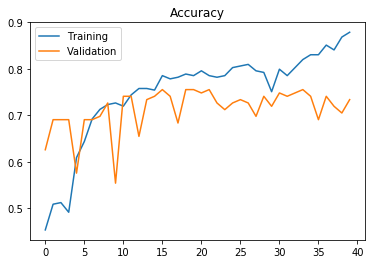

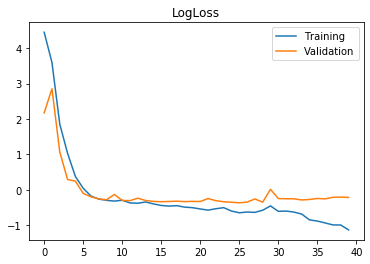

In [0]:
# Affichage des courbes d'apprentissage
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(["Training", "Validation"])
plt.title("Accuracy")
plt.figure()
plt.plot(np.log(history.history['loss']))
plt.plot(np.log(history.history['val_loss']))
plt.legend(["Training", "Validation"])
plt.title("LogLoss")

In [0]:
from tensorflow.keras.models import load_model

In [0]:
# Chargement du modèle d'entropie minimale précédemment sauvegardé
mdl = load_model(path + "best_loss.hdf5")

In [0]:
# Calcul du score de précision de ce modèle sur le jeu de test
print(mdl.evaluate(x_test, to_categorical(y_test)))

33/33 [==============================] - 0s 2ms/sample - loss: 0.4795 - acc: 0.8485


[0.479492979519295, 0.8484849]

In [0]:
y_pred = mdl.predict_classes(x_test)

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90        23
           1       0.86      0.86      0.86         7
           2       0.00      0.00      0.00         3

    accuracy                           0.85        33
   macro avg       0.57      0.60      0.59        33
weighted avg       0.77      0.85      0.81        33



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# KFold

In [0]:
# StratifiedKFold => chaque sous ensemble possède la même répartition de classes que les autres => représentativité
fold = StratifiedKFold(n_splits=5, shuffle=True)

In [0]:
# Calcul des spectrogrammes de tous les fichiers du dataset
cv_all = to_spect(files)

100%|██████████| 461/461 [03:19<00:00,  2.01it/s]


In [0]:
# Ajout d'une dimension pour les canaux
cv_all = np.expand_dims(cv_all, 3)

In [0]:
# Callback
# Stoppe l'apprentissage quand la fonction de coût n'évolue plus au bout de "patience" epochs
# À la fin de l'apprentissage, les poids de l'epoch de coût minimal sons restaurés
# => Permet de ne pas avoir à sauvegarder le meilleur modèle
es = EarlyStopping(monitor="val_loss", patience=40, mode="min", restore_best_weights=True)

In [0]:
# Boucle de cross-validation
cv = [] # Liste contenant les scores de précision de chaque itération
for cv_train_idx, cv_val_idx in fold.split(cv_all, cats_files): # Récupération des indices de jeux d'apprentissage, validation et test de l'itération en cours
  x_cv_val = cv_all[cv_val_idx] # Jeu de validation
  y_cv_val = np.array(cats_files)[cv_val_idx] # Labels de validation
  cv_tt_idx, cv_test_idx = train_test_split(cv_train_idx, test_size=33, stratify=np.array(cats_files)[cv_train_idx]) # Indices des jeux d'apprentissage et test
  cv_x_train, cv_x_test = cv_all[cv_tt_idx], cv_all[cv_test_idx] # Jeux d'apprentissage et test
  cv_y_train, cv_y_test = np.array(cats_files)[cv_tt_idx], np.array(cats_files)[cv_test_idx] # Labels d'apprentissage et test
  model = CNN() # Création d'un nouveau modèle
  model.compile(loss="categorical_crossentropy", metrics=["acc"], optimizer="adam") # Compilation
  model.fit(x_train, to_categorical(y_train), epochs=40, batch_size=17, validation_data=(x_val, to_categorical(y_val)), callbacks=[es]) # Apprentissage
  cv.append(model.evaluate(x_test, to_categorical(y_test))[1]) # On ajoute la précision de l'itération à la liste

Train on 289 samples, validate on 139 samples
Epoch 1/40
289/289 [==============================] - 0s 2ms/sample - loss: 1.0568 - acc: 0.6436 - val_loss: 0.8423 - val_acc: 0.6906
Epoch 2/40
289/289 [==============================] - 0s 604us/sample - loss: 0.8664 - acc: 0.6955 - val_loss: 0.8102 - val_acc: 0.6906
Epoch 3/40
289/289 [==============================] - 0s 620us/sample - loss: 0.8214 - acc: 0.6955 - val_loss: 0.8269 - val_acc: 0.6906
Epoch 4/40
289/289 [==============================] - 0s 618us/sample - loss: 0.7946 - acc: 0.6955 - val_loss: 0.7881 - val_acc: 0.6906
Epoch 5/40
289/289 [==============================] - 0s 612us/sample - loss: 0.7866 - acc: 0.7059 - val_loss: 0.7737 - val_acc: 0.6978
Epoch 6/40
289/289 [==============================] - 0s 599us/sample - loss: 0.7733 - acc: 0.7232 - val_loss: 0.7746 - val_acc: 0.7050
Epoch 7/40
289/289 [==============================] - 0s 638us/sample - loss: 0.7513 - acc: 0.7370 - val_loss: 0.7991 - val_acc: 0.6906
Epoc

In [0]:
# Calcul de la moyenne des précisions de chaque itération
print("Précision en cross-validation :", np.mean(cv))

0.78181815
